#### Install system packages for ODBC

In [ ]:
!apt-get update
!apt-get install gcc
!apt-get install -y tdsodbc unixodbc-dev
!apt install unixodbc-bin -y
!apt-get clean 

#### Use this command to troubleshoot a failed pyodbc installation:
!pip install --upgrade --global-option=build_ext --global-option="-I/usr/local/include"  --global-option="-L/usr/local/lib" pyodbc

In [ ]:
!pip install pyodbc
!pip install pandas

In [3]:
!rm /etc/odbcinst.ini
!rm /etc/odbc.ini

In [4]:
!ln -s /tf/odbcinst.ini /etc/odbcinst.ini
!ln -s /tf/odbc.ini /etc/odbc.ini

In [5]:
!cat /tf/odbcinst.ini

[InterSystems ODBC35]
UsageCount=1
Driver=/tf/libirisodbcu35.so
Setup=/tf/libirisodbcu35.so
SQLLevel=1
FileUsage=0
DriverODBCVer=02.10
ConnectFunctions=YYN
APILevel=1
DEBUG=1
CPTimeout=<not pooled>



In [6]:
!cat /tf/odbc.ini

[user]
Driver=InterSystems ODBC35
Protocol=TCP
Host=irisimlsvr
Port=51773
Namespace=USER
UID=SUPERUSER
Password=SYS
Description=Sample namespace
Query Timeout=0
Static Cursors=0



In [7]:
!odbcinst -j

unixODBC 2.3.4
DRIVERS............: /etc/odbcinst.ini
SYSTEM DATA SOURCES: /etc/odbc.ini
FILE DATA SOURCES..: /etc/ODBCDataSources
USER DATA SOURCES..: /root/.odbc.ini
SQLULEN Size.......: 8
SQLLEN Size........: 8
SQLSETPOSIROW Size.: 8


#### Get an ODBC connection 

In [8]:
import pyodbc 
import time

dsn = 'IRIS QuickML demo via PyODBC'
server = 'irisimlsvr'
port = '1972'
database = 'USER' 
username = 'SUPERUSER' 
password = 'SYS' 
cnxn = pyodbc.connect('DRIVER={InterSystems ODBC35};SERVER='+server+';PORT='+port+';DATABASE='+database+';UID='+username+';PWD='+ password)

cnxn.setdecoding(pyodbc.SQL_CHAR, encoding='utf8')
cnxn.setdecoding(pyodbc.SQL_WCHAR, encoding='utf8')
cnxn.setencoding(encoding='utf8')
cursor = cnxn.cursor()

####  Prepare training data, and give a model name

In [16]:
dataTable = 'BitcoinRates'
dataTablePredict = 'BitcoinRatesResult'
dataColumn =  'Rate'
dataColumnPredict = "PredictedRate"
modelName = "SVR_model" # must be unique

#### Get bitcoin rate history rates

In [11]:
cursor.execute(f"CREATE TABLE {dataTable} ( id INT(32) AUTO_INCREMENT PRIMARY KEY, day DATE, rate FLOAT)")

In [12]:
import pandas as pd
from datetime import datetime, timedelta

rates = pd.read_csv("coin_Bitcoin.csv", sep=",")
rates['Date'] = pd.to_datetime(rates.Date)
rates['Rate'] = (rates['High']+rates['Low'])/2
del rates['SNo'], rates['Name'], rates['Symbol'], rates['High'], rates['Low'], rates['Open'], rates['Close'], rates['Volume'], rates['Marketcap']

last_year_rates = rates.loc[rates['Date'] >= datetime.today() - timedelta(days=365)]

last_year_rates.head()

,Date,Rate
2640,2020-07-21 23:59:59,9278.326487
2641,2020-07-22 23:59:59,9425.086202
2642,2020-07-23 23:59:59,9546.625572
2643,2020-07-24 23:59:59,9552.395478
2644,2020-07-25 23:59:59,9617.384605


#### Draw a chart of the bitcoin rate 

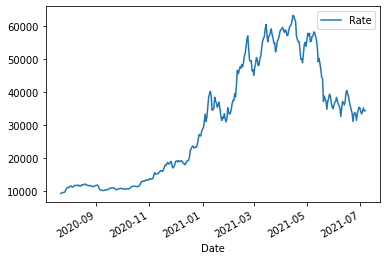

In [13]:
last_year_rates.plot.line('Date', 'Rate')

#### Insert data into IRIS

In [14]:
for index, row in last_year_rates.iterrows():
    cursor.execute(f"INSERT INTO {dataTable} VALUES ({index},{str(row['Date'])[0:10]}, {row['Rate']})")

#### Train model and make prediction

In [18]:
cursor.execute("CREATE MODEL %s PREDICTING (%s)  FROM %s" % (modelName, dataColumn, dataTable))
cursor.execute("TRAIN MODEL %s FROM %s" % (modelName, dataTable))
cursor.execute("Create Table %s (%s VARCHAR(100), %s VARCHAR(100))" % (dataTablePredict, dataColumnPredict, dataColumn))
cursor.execute("INSERT INTO %s SELECT TOP 50 PREDICT(%s) AS %s, %s FROM %s" % (dataTablePredict, modelName, dataColumnPredict, dataColumn, dataTable)) 
cnxn.commit()

In [21]:
# uncomment string if PredictedRate already exist
# cursor.execute("DROP TABLE %s" % (dataTablePredict))

#### Look at result

In [22]:
from IPython.display import display

result = pd.read_sql("SELECT * from %s ORDER BY ID" % dataTablePredict, cnxn)
result.head(10)

,PredictedRate,Rate
0,9766.4853515625,9278.326487345001
1,9766.4853515625,9425.086201965001
2,9766.4853515625,9546.625571864999
3,9766.4853515625,9552.3954784
4,9766.4853515625,9617.384604610001
5,9980.1630859375,9838.327433710001
6,10715.94921875,10601.095934425
7,10984.1982421875,10918.47965265
8,11114.5029296875,11080.26920515
9,11114.5029296875,11032.40603765


#### Check model accuracy

When training the model, the accuracy is considered satisfactory if the value is greater than 95%.

In [23]:
result['Deviation'] = abs(result['Rate'].astype(float) - result['PredictedRate'].astype(float))/result['Rate'].astype(float)
mape = result['Deviation'].sum()*100/result['Deviation'].count()
accuracy = 100-mape
accuracy


98.43334650997019

In [ ]:
cnxn.close()